In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential,Model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,  BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import shutil
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
import imghdr

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Step 1: Load and Preprocess Images

In [6]:
import imghdr

def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                # Check if the file is a valid image
                if imghdr.what(file_path) in ['jpeg', 'png', 'jpg']:
                    try:
                        img = load_img(file_path, target_size=(128, 128), color_mode="grayscale")
                        img_array = img_to_array(img) / 255.0  # Normalize pixel values
                        images.append(img_array)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error loading image {file_path}: {e}")
    return np.array(images), np.array(labels)


# Load data
data_folder = './Materials_data'
images, labels = load_images_from_folder(data_folder)

# Shuffle data to ensure proper distribution
images, labels = shuffle(images, labels, random_state=42)

# Encode string labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the encoded labels
images_train, images_val, labels_train, labels_val = train_test_split(
    images, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

# Verify class distribution
print("Training set class distribution:", Counter(labels_train))
print("Validation set class distribution:", Counter(labels_val))



Training set class distribution: Counter({0: 37, 6: 33, 1: 29, 9: 29, 7: 28, 4: 28, 8: 26, 3: 26, 5: 25, 2: 24, 10: 24, 86: 20, 152: 16, 125: 16, 109: 16, 121: 16, 75: 16, 162: 16, 68: 16, 84: 16, 123: 16, 80: 16, 101: 16, 114: 16, 38: 16, 56: 16, 39: 16, 70: 16, 50: 16, 49: 16, 33: 16, 127: 16, 59: 16, 53: 16, 135: 16, 157: 16, 119: 16, 63: 16, 145: 16, 166: 16, 96: 16, 163: 16, 54: 16, 102: 16, 165: 16, 55: 16, 73: 16, 93: 16, 99: 16, 159: 16, 158: 16, 78: 16, 65: 16, 136: 16, 133: 16, 108: 16, 64: 16, 11: 16, 74: 16, 51: 16, 69: 16, 111: 16, 20: 16, 141: 16, 52: 16, 72: 16, 81: 16, 142: 16, 66: 16, 42: 16, 134: 16, 85: 16, 37: 16, 25: 16, 126: 16, 171: 16, 103: 16, 115: 16, 118: 16, 61: 16, 150: 16, 143: 16, 30: 16, 36: 16, 131: 16, 71: 16, 146: 16, 173: 16, 116: 16, 128: 16, 149: 16, 16: 16, 13: 16, 15: 16, 41: 16, 14: 16, 57: 16, 104: 16, 67: 16, 21: 16, 47: 16, 153: 16, 100: 16, 87: 16, 113: 16, 151: 16, 32: 16, 170: 16, 28: 16, 148: 16, 90: 16, 124: 16, 130: 16, 132: 16, 155: 16

# Step 2: Build CNN Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, MaxPooling2D, Dropout,
                                     GlobalAveragePooling2D, Dense)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

def build_model():
    num_classes = len(set(encoded_labels))  # Ensure `encoded_labels` is defined
    model = Sequential()
    
    # Adjusted to double blocks up to size 512
    for filters in [64, 128, 256, 512]:  # Sizes up to 512
        for _ in range(9):  # Double the blocks
            model.add(Conv2D(filters, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
            model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2 if filters < 512 else 0.3))  # Increased dropout for larger layers
    
    # Global Average Pooling
    model.add(GlobalAveragePooling2D())
    
    # Fully Connected Layers
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Instantiate and train the model
model = build_model()

# Data Augmentation and Training
data_gen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = data_gen.flow(images_train, labels_train, batch_size=32)
val_gen = ImageDataGenerator().flow(images_val, labels_val, batch_size=32)

# Train the model
model.fit(train_gen, validation_data=val_gen, epochs=500)

# Save the model
model.save('model.h5')


Epoch 1/500
92/92 [==============================] - 36s 335ms/step - loss: 11.3716 - accuracy: 0.0058 - val_loss: 10.1378 - val_accuracy: 0.0054
Epoch 2/500
92/92 [==============================] - 28s 302ms/step - loss: 11.3391 - accuracy: 0.0041 - val_loss: 10.7100 - val_accuracy: 0.0054
Epoch 3/500
92/92 [==============================] - 28s 305ms/step - loss: 11.3535 - accuracy: 0.0051 - val_loss: 11.1821 - val_accuracy: 0.0054
Epoch 4/500
92/92 [==============================] - 29s 311ms/step - loss: 11.1991 - accuracy: 0.0078 - val_loss: 11.7082 - val_accuracy: 0.0054
Epoch 5/500
92/92 [==============================] - 29s 317ms/step - loss: 11.1421 - accuracy: 0.0078 - val_loss: 11.5705 - val_accuracy: 0.0054
Epoch 6/500
92/92 [==============================] - 30s 322ms/step - loss: 11.0794 - accuracy: 0.0106 - val_loss: 12.3962 - val_accuracy: 0.0000e+00
Epoch 7/500
92/92 [==============================] - 30s 323ms/step - loss: 11.0912 - accuracy: 0.0068 - val_loss: 14.08

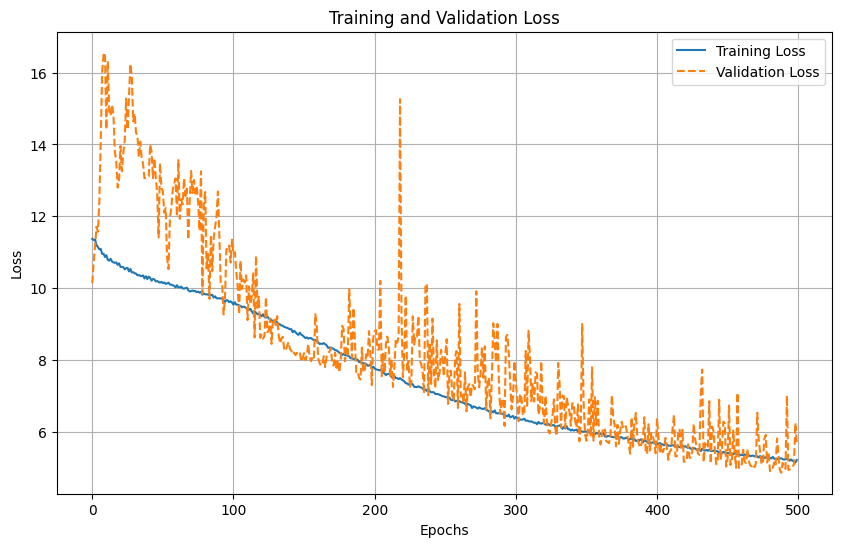

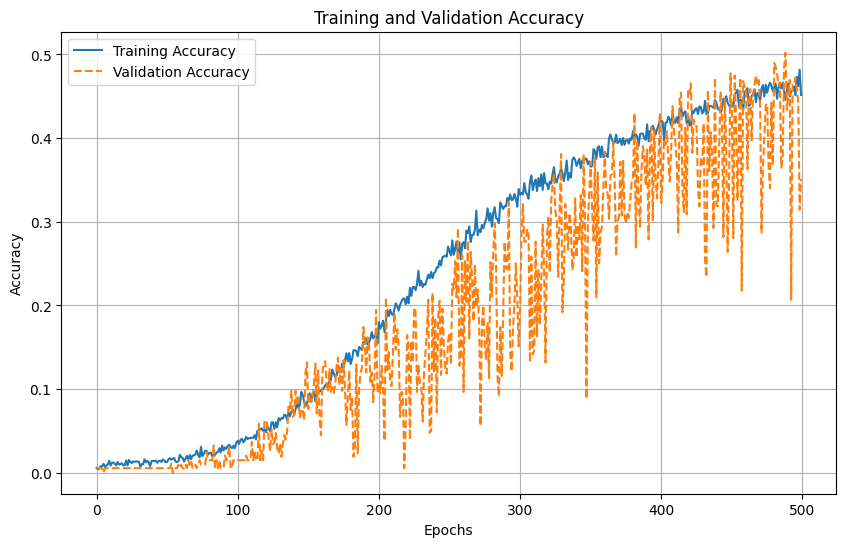

In [22]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of the model.fit() method, capturing training history
history = model.history

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Find Similar Material

In [23]:
# load model
from tensorflow.keras.models import load_model
model = load_model('model.h5')
# Step 5: Feature Extraction and Similarity Calculation
feature_extractor = Sequential(model.layers[:-1])  # Remove the output layer for feature extraction

def extract_features(image):
    return feature_extractor.predict(image[np.newaxis, ...])

def format_material_details(label):
    # Parse the label to extract material details
    parts = label.split("-")  # Example: '1-20.20.20.20-1'
    material_id = parts[0]
    attributes = parts[1].split(".")
    bend_strength = attributes[0]
    strength = attributes[1]
    deformation_strength = attributes[2]
    deformation_rate = attributes[3]
    face = "正面" if parts[-1] == "1" else "侧面"
    return f"材料{material_id}，弯曲强度：{bend_strength}，强度：{strength}，变形强度：{deformation_strength}，变形率：{deformation_rate}, {face}"

def find_most_similar(input_image_path):
    input_img = load_img(input_image_path, target_size=(128, 128), color_mode="grayscale")
    input_array = img_to_array(input_img) / 255.0
    input_features = extract_features(input_array)

    similarities = []
    for idx, image in enumerate(images):
        image_features = extract_features(image)
        similarity = cosine_similarity(input_features.reshape(1, -1), image_features.reshape(1, -1))[0][0]
        similarities.append((similarity, labels[idx]))

    # Sort similarities in descending order
    similarities = sorted(similarities, key=lambda x: x[0], reverse=True)

    # Extract unique labels with their percentage matches
    unique_results = []
    seen_labels = set()
    for similarity, label in similarities:
        if label not in seen_labels:
            seen_labels.add(label)
            percentage = similarity * 100  # Convert to percentage
            unique_results.append((label, percentage))
        if len(unique_results) == 3:  # Limit to top 3 unique labels
            break

    # Format results
    formatted_results = []
    for i, (label, percentage) in enumerate(unique_results, start=1):
        material_details = format_material_details(label)
        formatted_results.append(f"{i}. 相似度：{percentage:.2f}%：{material_details}")
    
    return formatted_results

ValueError: The channel dimension of the inputs should be defined. The input_shape received is (None, None, None, None), where axis -1 (0-based) is the channel dimension, which found to be `None`.

In [12]:
# def extract_features(image):
#     raw_features = feature_extractor.predict(image[np.newaxis, ...])  # Add batch dimension
#     return raw_features.flatten()  # Flatten to 1D

# Path to the input test image
result_string = ""
# Validate and process images
for path in os.listdir('./testing'):
    input_image_path = os.path.join('./testing', path)
    if imghdr.what(input_image_path) in ['jpeg', 'png', 'jpg']:
        try:
            # Call the function to find the top 3 most similar unique materials
            top_3_results = find_most_similar(input_image_path)

            # Print the results
            result_string += "True label:" + path + "\n"
            result_string += "最相似材料:"
            for result in top_3_results:
                result_string += result
            result_string += "\n"
        except Exception as e:
            print(f"Error processing file {input_image_path}: {e}")
    else:
        print(f"Skipped non-image file: {input_image_path}")

print(result_string)
# input_image_path = './第一组测试素材/1-10.20.20.20-2.jpg'

# # Call the function to find the top 3 most similar unique materials
# top_3_results = find_most_similar(input_image_path)

# # Print the results
# print("最相似材料：")
# for result in top_3_results:
#     print(result)

Error processing file ./testing\e93062093123dc11db5e24736c53834.png: in user code:

    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engi

In [13]:
def test_folder(folder_path):
    total_images = 0
    correct_predictions = 0
    incorrect_results = []  # To log incorrect predictions

    # Loop through all images in the folder
    for file in os.listdir(folder_path):
        if file.endswith('.jpg') or file.endswith('.png'):  # Ensure only image files are processed
            total_images += 1
            image_path = os.path.join(folder_path, file)

            # Extract the true label from the filename
            true_label = file.split('-')[0]  # Assuming label is before the first '-'

            # Predict the most similar material
            top_3_results = find_most_similar(image_path)

            # Extract the predicted label from the top result
            top_result = top_3_results[0]
            predicted_label = top_result.split("：")[-1].split("，")[0].strip("材料")  # Extract the predicted label

            # Check if the prediction is correct
            if true_label == predicted_label:
                correct_predictions += 1
            else:
                incorrect_results.append((file, true_label, predicted_label))

    # Calculate accuracy
    accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0

    # Print results
    print(f"Total Images Tested: {total_images}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Incorrect Predictions: {len(incorrect_results)}")
    print(f"Accuracy: {accuracy:.2f}%")

    # Log incorrect results
    if incorrect_results:
        print("\nIncorrect Predictions:")
        for file, true_label, predicted_label in incorrect_results:
            print(f"File: {file}, True Label: {true_label}, Predicted Label: {predicted_label}")

    return accuracy

In [14]:
folder_path = "./第一组测试素材"
accuracy = test_folder(folder_path)
print(f"Overall Test Accuracy: {accuracy:.2f}%")

ValueError: in user code:

    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 128, 128, 1)
